# BERTScore

This notebook demonstrates the evaluation of a model on test data during training.

In [1]:
!pip install transformers==3.0.1 bert_score==0.3.9
from bert_score import score

     |████████████████████████████████| 757kB 35.2MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 901kB 48.6MB/s 
     |████████████████████████████████| 3.0MB 48.0MB/s 
     |████████████████████████████████| 1.2MB 37.0MB/s 


<h1><center>BERTScore on Week 8's Assignment</center></h1>

## Installing Modules

In [2]:
!pip install pytorch_lightning torchmetrics tableprint spacy==3
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     |████████████████████████████████| 819kB 35.0MB/s 
     |████████████████████████████████| 235kB 34.6MB/s 
     |████████████████████████████████| 12.7MB 240kB/s 
     |████████████████████████████████| 829kB 46.9MB/s 
     |████████████████████████████████| 122kB 57.6MB/s 
     |████████████████████████████████| 645kB 53.3MB/s 
     |████████████████████████████████| 10.6MB 211kB/s 
     |████████████████████████████████| 624kB 58.7MB/s 
     |████████████████████████████████| 9.1MB 50.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 460kB 53.1MB/s 
     |████████████████████████████████| 1.3MB 50.7MB/s 
     |████████████████████████████████| 143kB 58.1MB/s 
     |████████████████████████████████| 296kB 57.6MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=0fbbfab1259ee2da213f50707106a765f65bc34836e6b9c7eb262a7613b66a0f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dc

2021-07-05 06:49:03.455261: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.7MB 224kB/s 
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-07-05 06:49:11.127032: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 19.3MB 157kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


## Imports

In [3]:
# Import Libraries
import random
from typing import Iterable, List, Tuple
import pandas as pd
import sys, os, pickle
import math
import matplotlib.pyplot  as plt
import numpy as np
import spacy

# PyTorch related
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# My Custom Code
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import tableprint as tp



In [4]:
# Manual Seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Language Definitions

In [6]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

## Tokenizers

In [7]:
token_transform[SRC_LANGUAGE]  = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

## Yield Function

This yields the tokens for the texts and will be used to build the vocab

In [8]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

## Special Tokens

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

Build the vocab here

In [10]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 1.64MB/s]


### Setting the default index as the <unk> token

In [11]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [12]:
len(vocab_transform['de'])

19215

In [13]:
len(vocab_transform['en'])

10838

## Collator

In [14]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

## DataLoader

In [15]:
BATCH_SIZE = 32
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 270kB/s]
mmt16_task1_test.tar.gz: 100%|██████████| 43.9k/43.9k [00:00<00:00, 263kB/s]


## Model

### Boilerplate Code for PyTorch Lightning

In [16]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        self.trgs = []
        self.preds = []

        

    def training_step(self, batch, batch_idx):
        src, trg = batch 
        output = self(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, trg = batch  
        output = self(src, trg, 0)

        
        out = output.argmax(2) 
        
        o = torch.transpose(out,0,1)
        t = torch.transpose(trg,0,1)
        for o1, t1 in zip(o,t):
          stop_ind_trg = (t1==3).nonzero()[0].item() # stop when <eos> token is found
          if any(o1==3) == False: # if <eos> token is not found
            stop_ind_pred = len(o1)   # use complete sentence
          else:
            stop_ind_pred = (o1==3).nonzero()[0].item() # stop when <eos> token is found

          trg_sent_i = t1[:stop_ind_trg+1]
          pred_sent_i = o1[:stop_ind_pred+1]

          trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]
          pred_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in pred_sent_i[1:stop_ind_pred]]

          trg_sent = " ".join(trg_sent_tok)
          pred_sent = " ".join(pred_sent_tok)


          self.trgs.append(trg_sent)
          self.preds.append(pred_sent)

        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        
        
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.sanity_checking:
          print('sanity check')
          return
        P, R, F1 = score(self.preds, self.trgs, lang="en", verbose=False)
        P, R, F1 = round(P.mean().item(),3), round(R.mean().item(), 3), round(F1.mean().item(), 3)

        self.trgs = []
        self.preds = []
        
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss, 'Valid P':P, 'Valid R':R, 'Valid F1':F1}
        if self.table_context is None:
          self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss', 'Valid P', 'Valid R', 'Valid F1'])
          self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item(), P, R, F1])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
          self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [17]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        output, hidden = self.rnn(embedded)
        
        return hidden

### Decoder

In [18]:
class Decoder(pl.LightningModule):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + hid_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0) 
        embedded = self.dropout(self.embedding(input))
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)
        prediction = self.fc_out(output)
        return prediction, hidden

### Seq2Seq Model

In [19]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        self.loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

        assert encoder.hid_dim == decoder.hid_dim, "Hidden Dimensions of Encoder and Decoder must be equal"
            
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        context = self.encoder(src)
        hidden = context
                        
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            output, hidden = self.decoder(input, hidden, context)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

## Model Initialization and Summary

In [20]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])


ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)


### Model Checkpoint

In [21]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [22]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2_Assign_9', version=0)
trainer = pl.Trainer(max_epochs=5, num_sanity_val_steps=0, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 6.1 M 
2 | decoder | Decoder          | 18.6 M
---------------------------------------------
24.7 M    Trainable params
0         Non-trainable params
24.7 M    Total params
98.916    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:42: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  'Your `IterableDataset` has `__len__` defined.'



╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │     Valid P │     Valid R │    Valid F1 │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      74.355 │      4.3088 │      68.656 │      4.2291 │       0.889 │       0.886 │       0.887 │


│           2 │      28.446 │       3.348 │      57.394 │      4.0499 │       0.906 │       0.897 │       0.901 │


│           3 │      18.098 │      2.8958 │      58.138 │      4.0628 │        0.91 │       0.901 │       0.905 │


│           4 │       13.48 │      2.6012 │      60.358 │      4.1003 │       0.913 │       0.904 │       0.908 │


│           5 │      11.327 │      2.4272 │      67.572 │      4.2132 │       0.917 │       0.906 │       0.911 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

## Training Log

In [23]:
root='./csv_logs/' + 'END2_Assign_9' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

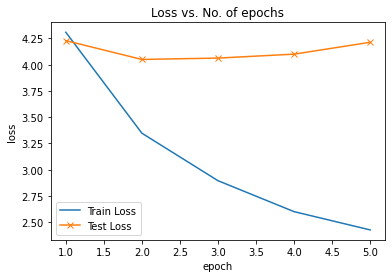

In [24]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

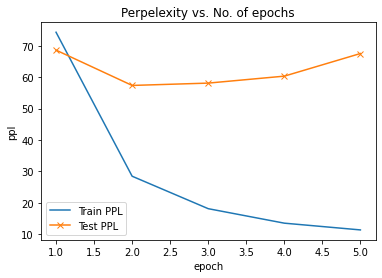

In [25]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('epoch')
plt.ylabel('ppl')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

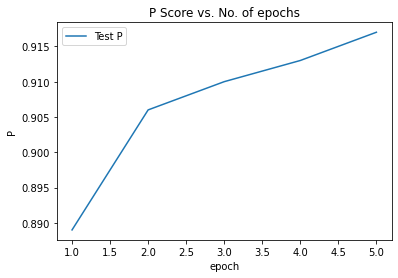

In [26]:
plt.plot(metrics['epoch'], metrics['Valid P'], label="Test P")
plt.xlabel('epoch')
plt.ylabel('P')
plt.legend()
plt.title('P Score vs. No. of epochs');

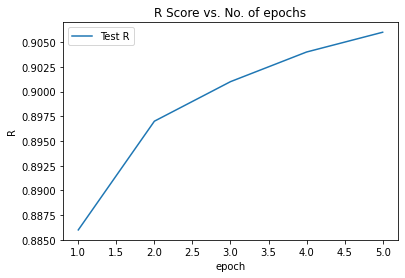

In [27]:
plt.plot(metrics['epoch'], metrics['Valid R'], label="Test R")
plt.xlabel('epoch')
plt.ylabel('R')
plt.legend()
plt.title('R Score vs. No. of epochs');

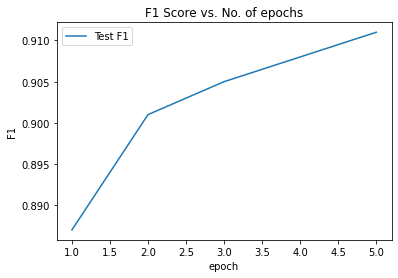

In [28]:
plt.plot(metrics['epoch'], metrics['Valid F1'], label="Test F1")
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()
plt.title('F1 Score vs. No. of epochs');

# Conclusion

We can see that in general, the scores increase, which means that our model is learning and improving